In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from config import main_path_era
from id_selector import IDSelector
import dataset
import unet

### generate ID list

In [2]:
class_ids = IDSelector(main_path = main_path_era, 
                       start_year = 2004, 
                       end_year = 2019, 
                       month_only=[4,5,6,7], year_only=[2004], mcs_only=True, 
                       percent_train=0.7, percent_validate=0.1,)

# here we generate the list of IDs by loading from a presaved dictionary
IDlist = class_ids.generate_IDarray(dict_freq='3H')

# here we shuffle and split the IDs into a testing and training set
train_IDs, valid_IDs, test_IDs = class_ids.generate_traintest_split(IDlist, seed=0)

starting ID generation...
ID generation complete.


In [3]:
print(f"Training set contains ",len(train_IDs)," total training MCSs.")

Training set contains  513  total training MCSs.


### initiate training, validation, and testing data

In [4]:
variables = ["cp","u850", "v850", "q850"]

In [19]:
training_generator = dataset.CustomDataset(list_IDs = train_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/3H/", 
                                              variable = variables, 
                                              batch_size = 16, dim = (121, 321), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = True, 
                                              norm='zscore',
                                              )
train_load = DataLoader(training_generator, batch_size=1, shuffle=False, drop_last=False)


validating_generator = dataset.CustomDataset(list_IDs = valid_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/3H/", 
                                              variable = variables, 
                                              batch_size = 16, dim = (121, 321), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = False, 
                                              norm='zscore',
                                              )
valid_load = DataLoader(validating_generator, batch_size=1, shuffle=False, drop_last=False)


testing_generator = dataset.CustomDataset(list_IDs = test_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/3H/", 
                                              variable = variables, 
                                              batch_size = 1, dim = (121, 321), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = False, 
                                              norm='zscore',
                                              )
test_load = DataLoader(testing_generator, batch_size=1, shuffle=False, drop_last=False)

### training functions

In [6]:
def train(model, dataloader, weights=None):
    """
    Training function.
    
    Args:
        model (torch): pytorch neural network.
        dataloader (torch): pytorch dataloader.
        weights (boolean): weights for custom loss.
    
    """
    model.train()
    
    running_loss = 0.0
    corrcoef_loss = 0.0
    
    for data in dataloader:
        
        img_noisy = data['train'].squeeze()
        img_noisy = img_noisy.to(device)
        
        img_label = data['test'].squeeze()
        img_label = img_label.to(device)

        outputs = model(img_noisy.float())
        
        try:
            if not weights:
                loss = criterion(outputs, img_label.float())
                
        except ValueError:
            loss = criterion(outputs, img_label.float(), weights)
            
        closs = secondcrt(outputs, img_label.float())
        
        optimizer.zero_grad()   # back prop
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        corrcoef_loss += closs.item()
    
    train_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)
    
    return train_loss, coef_loss

In [7]:
def validate(model, dataloader, weights=None):
    """
    Validation function.
    
    Args:
        model: pytorch neural network.
        dataloader: pytorch dataloader.
        weights (boolean): weights for custom loss.
    
    """
    model.eval()
    
    running_loss = 0.0
    corrcoef_loss = 0.0
    
    with torch.no_grad():
        
        for i, data in enumerate(dataloader):

            img_noisy = data['train'].squeeze()
            img_noisy = img_noisy.to(device)

            img_label = data['test'].squeeze()
            img_label = img_label.to(device)

            outputs = model(img_noisy.float())
            
            try:
                if not weights:
                    loss = criterion(outputs, img_label.float())

            except ValueError:
                loss = criterion(outputs, img_label.float(), weights)

            closs = secondcrt(outputs, img_label.float())

            running_loss += loss.item()
            corrcoef_loss += closs.item()
        
    val_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)
    
    return val_loss, coef_loss

### initiate unet for training

In [8]:
net = unet.UNet(n_channels=4, n_classes=2)

In [9]:
LEARNING_RATE = 1e-4

# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, amsgrad=False)

# the loss function
criterion = nn.MSELoss(reduction='sum')
secondcrt = unet.IoULoss()

In [10]:
device = unet.get_device()
print(device)
net.to(device)

cpu


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [11]:
NUM_EPOCHS = 30

train_loss = []
valid_loss = []

train_corr = []
valid_corr = []

for enum, epoch in enumerate(range(NUM_EPOCHS)):
    
    t_loss, t_corr = train(net, train_load, weights = None)
    v_loss, v_corr = validate(net, valid_load, weights = None)
    
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    
    train_corr.append(t_corr)
    valid_corr.append(v_corr)
    
    print(
        f"Epoch {epoch + 1} of {NUM_EPOCHS}; Train Loss: {t_loss:.4f}, Train IoU: {t_corr:.4f}; Val Loss: {v_loss:.4f}, Val IoU: {v_corr:.4f}")

Epoch 1 of 30; Train Loss: 403655.4253, Train IoU: 0.6301; Val Loss: 291365.9125, Val IoU: 0.6191
Epoch 2 of 30; Train Loss: 118701.8237, Train IoU: 0.5762; Val Loss: 233959.9484, Val IoU: 0.5800
Epoch 3 of 30; Train Loss: 92469.1753, Train IoU: 0.5678; Val Loss: 96887.0156, Val IoU: 0.5698
Epoch 4 of 30; Train Loss: 65579.7050, Train IoU: 0.5570; Val Loss: 104798.9078, Val IoU: 0.5593
Epoch 5 of 30; Train Loss: 48995.8103, Train IoU: 0.5485; Val Loss: 46961.4445, Val IoU: 0.5480
Epoch 6 of 30; Train Loss: 37693.3148, Train IoU: 0.5412; Val Loss: 37274.7133, Val IoU: 0.5414
Epoch 7 of 30; Train Loss: 31640.2032, Train IoU: 0.5361; Val Loss: 31470.3637, Val IoU: 0.5363
Epoch 8 of 30; Train Loss: 28009.2162, Train IoU: 0.5323; Val Loss: 27860.5820, Val IoU: 0.5324
Epoch 9 of 30; Train Loss: 25720.1552, Train IoU: 0.5293; Val Loss: 26196.8285, Val IoU: 0.5298
Epoch 10 of 30; Train Loss: 24248.0159, Train IoU: 0.5271; Val Loss: 25868.8480, Val IoU: 0.5282
Epoch 11 of 30; Train Loss: 23205.

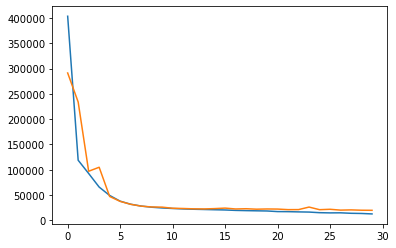

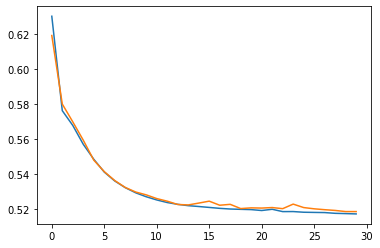

In [12]:
%matplotlib inline
plt.plot(train_loss[:]);
plt.plot(valid_loss[:]);
plt.show()

plt.plot(train_corr[:]);
plt.plot(valid_corr[:]);
plt.show()

In [13]:
#torch.save(net.state_dict(), '../trained_models/model_week4_temp.pt')

### evaluation

In [43]:
def generate_predictions(model, IDs, torch_dataset, torch_dataloader, num_classes=2):
    
    shape_0 = IDs.shape[0]
    shape_1 = torch_dataset.__getitem__(0)['train'].squeeze().shape[1]
    shape_2 = torch_dataset.__getitem__(0)['train'].squeeze().shape[2]

    predictions_ = np.zeros((shape_0, num_classes, shape_1, shape_2))
    pred_labels_ = np.zeros((shape_0, num_classes, shape_1, shape_2))
    
    indx_ = []
    model.eval()
    count_ = 0

    with torch.no_grad():
        
        for i, data in enumerate(torch_dataloader):
            
            img_noisy = data['train'].squeeze(0)
            img_noisy = img_noisy.to(device)
            
            img_label = data['test'].squeeze(0)
            img_label = img_label.to(device)
            
            indx_.append(data['minibatch_indx'])
            
            outputs = model(img_noisy.float())
            
            for out_ in range(outputs.shape[0]):
                
                predictions_[count_, ...] = outputs.cpu()[out_, ...]
                pred_labels_[count_, ...] = img_label.cpu()[out_, ...]
                
                count_ += 1
                
    indx_ = np.array([ind for i in indx_ for ind in i.numpy()])
    
    return predictions_.astype(np.float32), pred_labels_.astype(np.float32), indx_

In [44]:
predictions_, pred_labels_, indx_ = generate_predictions(net, test_IDs, testing_generator, test_load,)

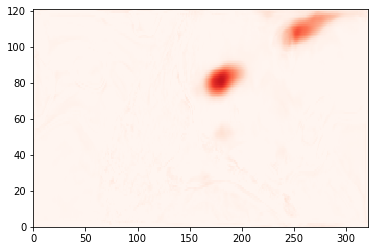

In [72]:
plt.pcolormesh(predictions_[102,0,:,:], vmin=0, vmax=1, cmap='Reds'); plt.show()

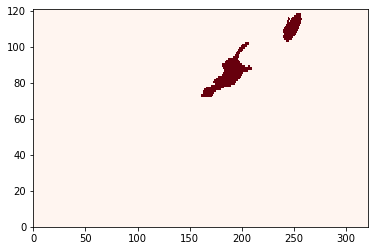

In [73]:
plt.pcolormesh(pred_labels_[102,0,:,:], vmin=0, vmax=1, cmap='Reds'); plt.show()